In [20]:
import numpy as np
import sounddevice as sd
import time
from IPython.display import Audio 
from matplotlib import pyplot as plt

(13, 100)


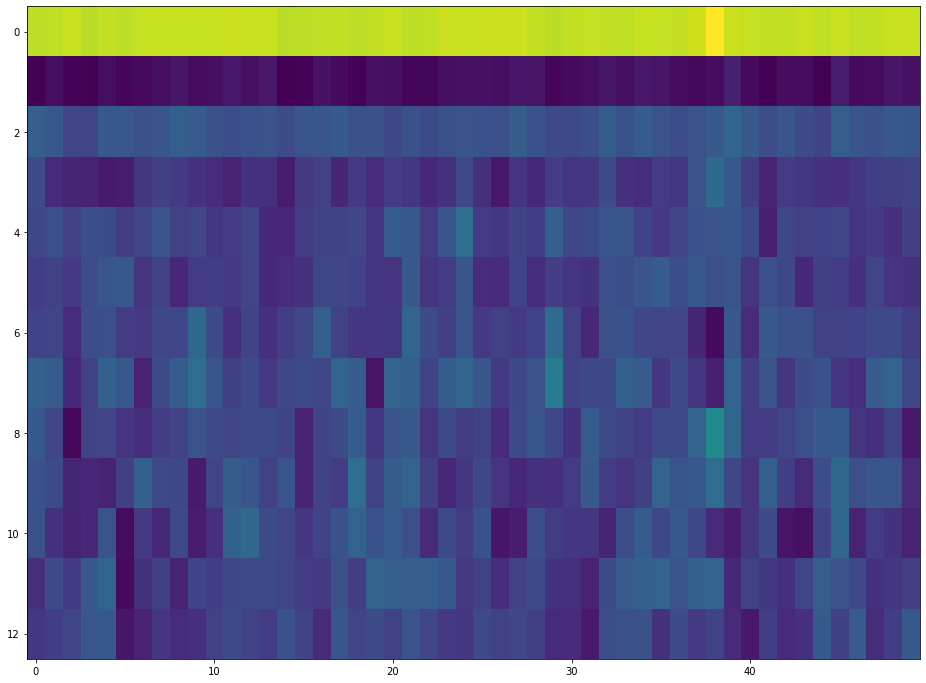

In [48]:
with open("audio/CMU-0E07000-CM00x-R7.npy", 'rb') as f:
    A = np.load(f)

A.shape
A[:,0].shape
A[:,1].shape
plt.figure(figsize=(16, 12))

print(A.T[:,:100].shape)
plt.figure(figsize=(16, 12))
plt.imshow(A.T[:,:100], interpolation='nearest', aspect='auto')

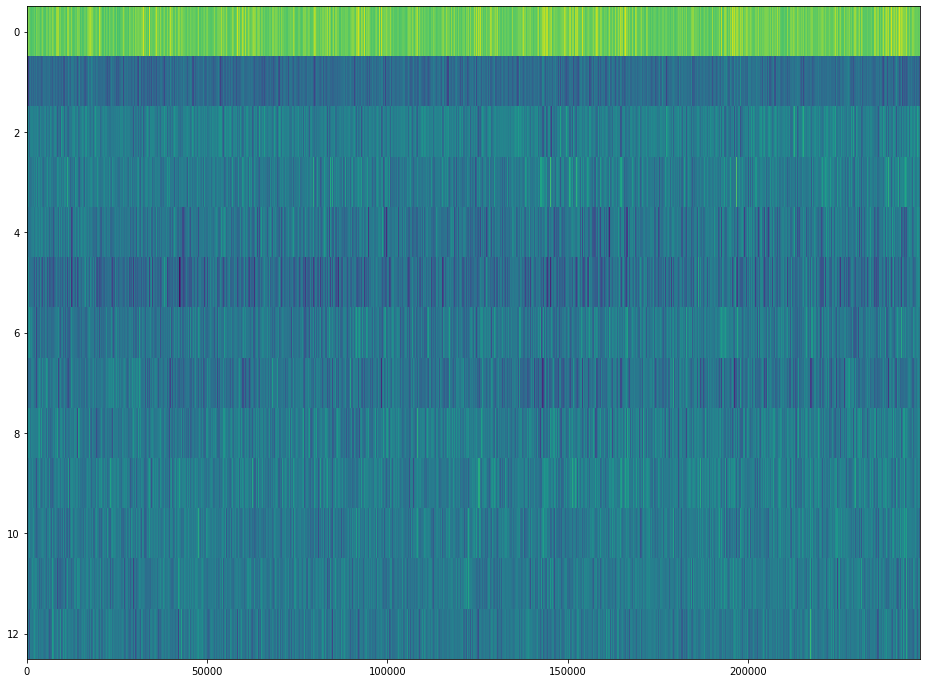

In [37]:
plt.figure(figsize=(16, 12))
plt.imshow(A.T, interpolation='nearest', aspect='auto')

In [ ]:
import math
import torch.nn as nn
import torch